In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import json
import os
import pickle
import re
import time

import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np
import tqdm

import tensorflow as tf
from tensorflow.keras import backend as K
print("TensorFlow version: {}".format(tf.VERSION))
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 1.12.0
Keras version: 2.1.6-tf


In [3]:
# flare-ai imports
from featureize.utils import feature_utils, fit_utils, plot_utils
from featureize.utils.plot_utils import DiagnosticViz
from featureize.features import action_features

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


# Set up TF session

In [4]:
sess = tf.Session()
K.set_session(sess)
K.set_learning_phase(0)

In [5]:
is_training = sess.graph.get_collection('is_training')

In [6]:
init_op = tf.variables_initializer(is_training)
sess.run(init_op)

In [7]:
K.get_value(is_training[0])

False

In [8]:
K.set_value(is_training[0], True)

In [9]:
K.get_value(is_training[0])

True

# Load Data

In [10]:
MODEL_READ_DIR = feature_utils.FLARE_DIR + 'flare-ai/models/'
GAME_STATE_DIR = feature_utils.FLARE_DIR + 'flare-ai/log/'
FEATURES_WRITE_DIR = feature_utils.FLARE_DIR + 'flare-ai/data/'

In [11]:
game_state_store = pd.HDFStore(FEATURES_WRITE_DIR + 'game_states_features_20190105_170223.h5')
print(game_state_store)


<class 'pandas.io.pytables.HDFStore'>
File path: /Users/leopekelis/flare/flare-ai/data/game_states_features_20190105_170223.h5



In [12]:
display('for some strange reason, this gamestate has swapped X and y?')
y = game_state_store.get('X')
X = game_state_store.get('y')

'for some strange reason, this gamestate has swapped X and y?'

In [13]:
with open(FEATURES_WRITE_DIR + 'game_states_20190105_170223.p', 'rb') as f:
    game_states = pickle.load(f)

In [14]:
game_states.keys()

dict_keys(['GAME_STATES_2018-07-29_05_04_28%99Y%FF\x7f', 'GAME_STATES_2018-08-05_23_33_24%C6]%FF\x7f', 'GAME_STATES_2018-08-05_23_36_24%C8[%FF\x7f', 'GAME_STATES_2018-07-29_05_16_25%93Q%FF\x7f', 'GAME_STATES_2018-07-29_05_23_05^V%FF\x7f', 'GAME_STATES_2018-07-29_05_05_493W%FF\x7f', 'GAME_STATES_2018-07-29_03_48_35MW%FF\x7f'])

# Load keras model

In [15]:
X.shape

(985179, 113)

In [16]:
X.columns.values

array(['e.stats.hp', 'e.stats.mp', 'e.stats.pos.x', 'e.stats.pos.y',
       'pc.stats.hp', 'pc.stats.mp', 'e.pc.dx', 'e.pc.dy', 'o_hp_0',
       'o_hp_1', 'o_hp_2', 'o_hp_3', 'o_hp_4', 'o_hp_5', 'o_hp_6',
       'o_hp_7', 'o_hp_8', 'o_hp_9', 'o_hp_10', 'o_hp_11', 'o_hp_12',
       'o_hp_13', 'o_hp_14', 'o_hp_15', 'o_hp_16', 'o_hp_17', 'o_hp_18',
       'o_hp_19', 'o_hp_20', 'o_hp_21', 'o_hp_22', 'o_hp_23', 'o_hp_24',
       'o_hp_25', 'o_hp_26', 'o_hp_27', 'o_hp_28', 'o_hp_29', 'o_hp_30',
       'o_hp_31', 'o_hp_32', 'o_hp_33', 'o_hp_34', 'o_hp_35', 'o_hp_36',
       'o_hp_37', 'o_hp_38', 'o_hp_39', 'o_hp_40', 'o_hp_41', 'o_hp_42',
       'o_hp_43', 'o_hp_44', 'o_hp_45', 'o_hp_46', 'o_hp_47', 'o_hp_48',
       'o_hp_49', 'o_hp_50', 'o_hp_51', 'o_hp_52', 'o_hp_53', 'o_hp_54',
       'o_hp_55', 'o_hp_56', 'o_hp_57', 'o_hp_58', 'o_hp_59', 'o_hp_60',
       'o_hp_61', 'o_hp_62', 'o_hp_63', 'o_hp_64', 'o_hp_65', 'o_hp_66',
       'o_hp_67', 'o_hp_68', 'o_hp_69', 'o_hp_70', 'o_hp_71', 'o_hp_

In [17]:
y.shape

(985179, 52)

In [18]:
y.columns.values

array(['R', 'R_discount', 'companion_0_hp', 'companion_10_hp',
       'companion_11_hp', 'companion_12_hp', 'companion_13_hp',
       'companion_14_hp', 'companion_15_hp', 'companion_16_hp',
       'companion_17_hp', 'companion_18_hp', 'companion_19_hp',
       'companion_1_hp', 'companion_2_hp', 'companion_3_hp',
       'companion_4_hp', 'companion_5_hp', 'companion_6_hp',
       'companion_7_hp', 'companion_8_hp', 'companion_9_hp', 'entity_hp',
       'entity_hp_diff', 'is_companion_0_alive', 'is_companion_10_alive',
       'is_companion_11_alive', 'is_companion_12_alive',
       'is_companion_13_alive', 'is_companion_14_alive',
       'is_companion_15_alive', 'is_companion_16_alive',
       'is_companion_17_alive', 'is_companion_18_alive',
       'is_companion_19_alive', 'is_companion_1_alive',
       'is_companion_2_alive', 'is_companion_3_alive',
       'is_companion_4_alive', 'is_companion_5_alive',
       'is_companion_6_alive', 'is_companion_7_alive',
       'is_companion_8_ali

In [19]:
y["R_discount"].describe()

count    985179.000000
mean          0.005455
std           0.688979
min         -50.000000
25%          -0.000101
50%           0.000000
75%           0.000000
max          25.499994
Name: R_discount, dtype: float64

In [20]:
model_params = {
    'l2': 0.0001,
    'adam': 0.001,
    'batch_size': 1000,
    'shuffle': True,
    'validation_split': 0,
    'epochs': 5,
    'input_shape': X.shape[1],
    'dropout_rate': 0.5,
}

In [21]:
def define_model(params):
    return tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(params['input_shape'],)),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(params['l2'])),
        # tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(rate=params['dropout_rate'], noise_shape=None, seed=None),
        tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dropout(rate=params['dropout_rate'], noise_shape=None, seed=None),
#         tf.keras.layers.Dense(16, activation='relu'),
#         tf.keras.layers.Dropout(rate=params['dropout_rate'], noise_shape=None, seed=None),
        tf.keras.layers.Dense(1),
    ])

In [22]:
model = define_model(model_params)

In [23]:
model.compile(optimizer=tf.train.AdamOptimizer(model_params['adam']),
              loss='mae',       
              metrics=['mse'])

In [24]:
model.fit(
    np.array(X, dtype=np.float32),
    np.array(y['R_discount'], dtype=np.float32),
    epochs=model_params['epochs'],
    batch_size=model_params['batch_size'],
    shuffle=True,
    validation_split=model_params['validation_split']
)

Epoch 1/5
985179/985179 [==============================] - 5s 5us/step - loss: 0.4827 - mean_squared_error: 2.2189
Epoch 2/5
985179/985179 [==============================] - 5s 5us/step - loss: 0.1401 - mean_squared_error: 0.4974
Epoch 3/5
985179/985179 [==============================] - 5s 5us/step - loss: 0.0996 - mean_squared_error: 0.4773
Epoch 4/5
985179/985179 [==============================] - 5s 5us/step - loss: 0.0877 - mean_squared_error: 0.4749
Epoch 5/5
985179/985179 [==============================] - 5s 5us/step - loss: 0.0794 - mean_squared_error: 0.4742


MODEL_WEIGHTS_PATH = "/Users/leopekelis/flare/flare-ai/models/Model.MDP_V0_20190111_214405.keras" 
model = fit_utils.define_prediction_model_keras()
model.build(input_shape=(10000,X.shape[1]))
model.load_weights(MODEL_WEIGHTS_PATH)

# Diagnostics

## Predict

In [25]:
K.get_value(is_training[0])

True

In [26]:
K.set_value(is_training[0], False)

In [27]:
K.get_value(is_training[0])

False

In [28]:
pred = pd.DataFrame(
    model.predict(np.array(X, dtype=np.float32), batch_size=1000),
    columns=['R_discount'],
    index=y.index
)

In [29]:
pred.describe()

,R_discount
count,985179.000000
mean,0.023242
std,0.019813
min,-2.413350
25%,0.015646
50%,0.019017
75%,0.028261
max,0.586339


/Users/leopekelis/anaconda3/envs/flare/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 13994 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/leopekelis/anaconda3/envs/flare/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/leopekelis/anaconda3/envs/flare/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


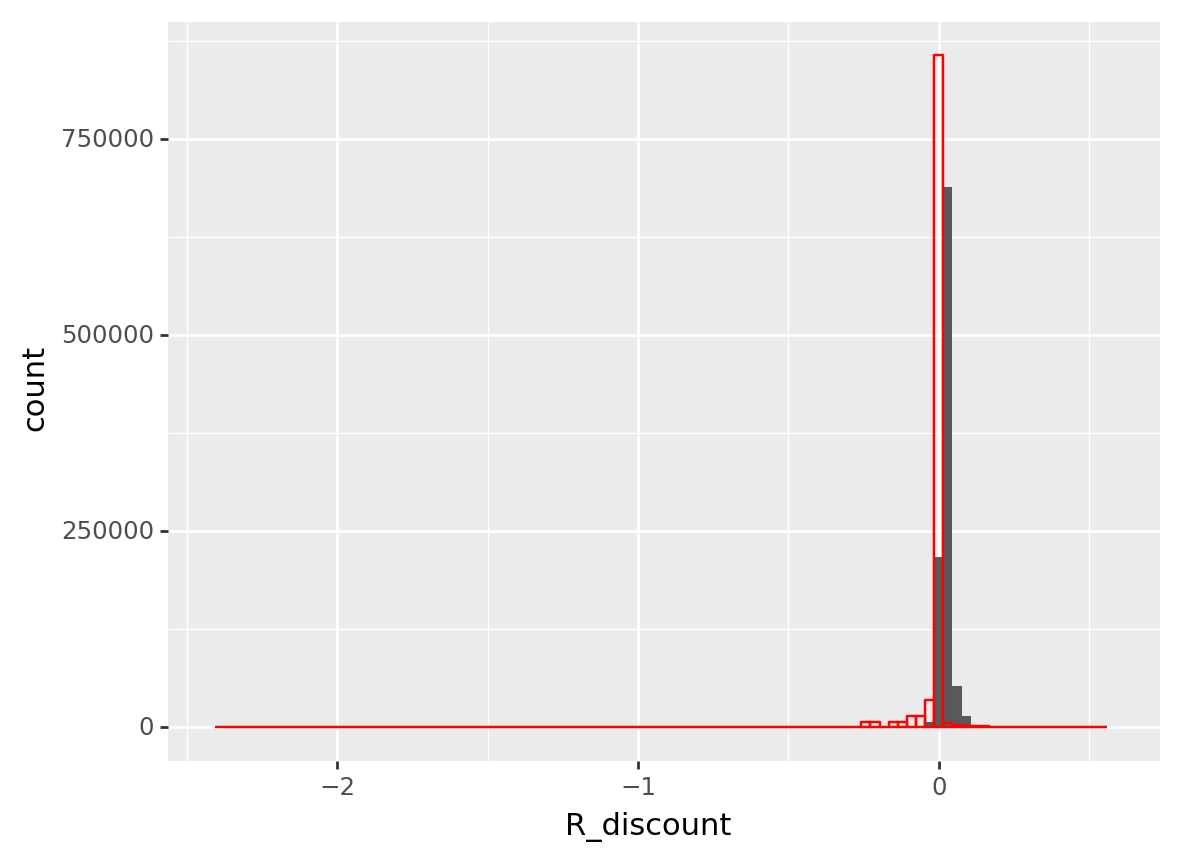

<ggplot: (7655418537)>

In [30]:
(
    ggplot(pred, aes(x='R_discount')) + geom_histogram(bins=100)
    + geom_histogram(data=y, color="red", fill=None, bins=100)
    + xlim(min(pred['R_discount']), max(pred['R_discount']))
)

In [31]:
low_score_idxs = pred.sort_values('R_discount').head().index.values
hi_score_idxs = pred.sort_values('R_discount', ascending=False).head().index.values

#low_score_idxs = X.index.values[low_score_idxs]
#hi_score_idxs = X.index.values[hi_score_idxs]

In [32]:
display(
    low_score_idxs,
    hi_score_idxs
)

array([('GAME_STATES_2018-07-29_05_16_25%93Q%FF\x7f', 18512, 3, 8.0),
       ('GAME_STATES_2018-07-29_05_16_25%93Q%FF\x7f', 18511, 3, 8.0),
       ('GAME_STATES_2018-07-29_05_16_25%93Q%FF\x7f', 18510, 3, 8.0),
       ('GAME_STATES_2018-07-29_05_16_25%93Q%FF\x7f', 18509, 3, 8.0),
       ('GAME_STATES_2018-07-29_05_16_25%93Q%FF\x7f', 18508, 3, 8.0)],
      dtype=object)

array([('GAME_STATES_2018-07-29_05_05_493W%FF\x7f', 10503, 2, 0.0),
       ('GAME_STATES_2018-07-29_05_05_493W%FF\x7f', 10504, 2, 0.0),
       ('GAME_STATES_2018-07-29_05_05_493W%FF\x7f', 10498, 2, 0.0),
       ('GAME_STATES_2018-07-29_05_05_493W%FF\x7f', 10499, 2, 0.0),
       ('GAME_STATES_2018-07-29_05_05_493W%FF\x7f', 10500, 2, 0.0)],
      dtype=object)

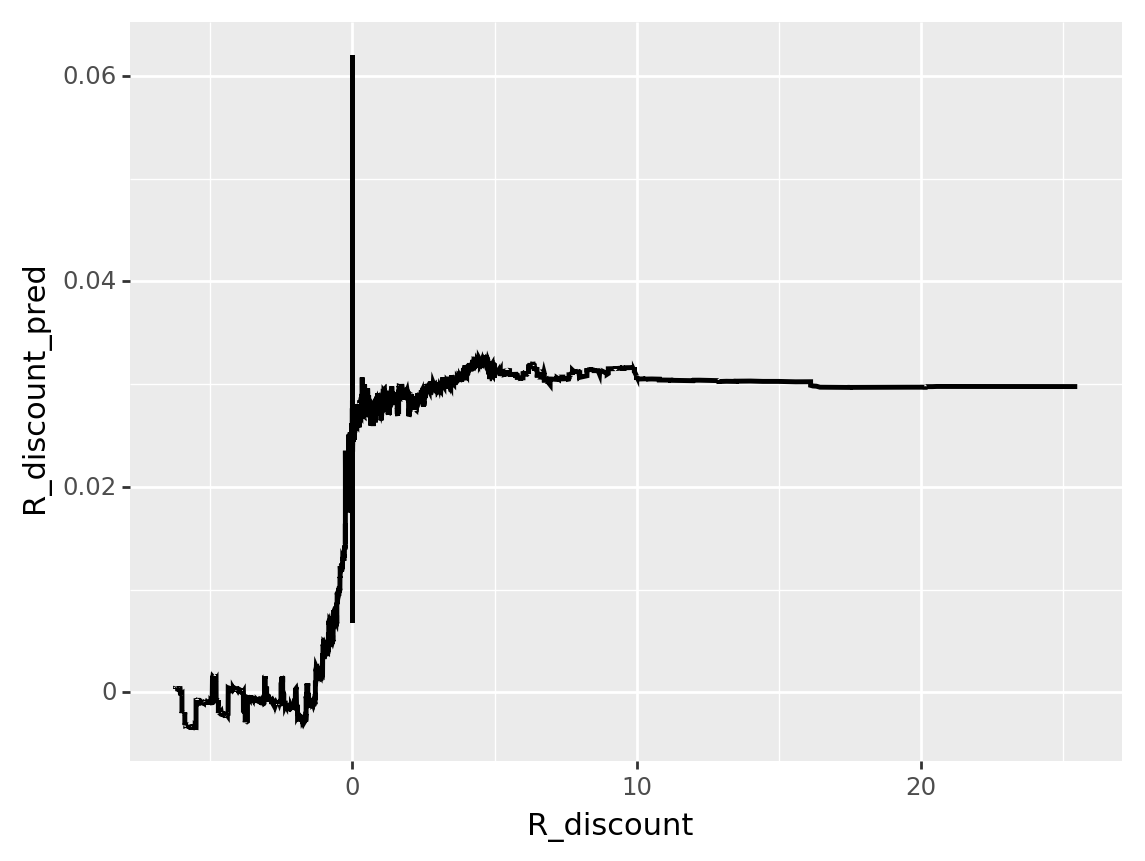

<ggplot: (7669673890)>

In [33]:
y[['R_discount']].join(pred, rsuffix='_pred').pipe( 
    lambda df:
    ggplot(df, aes(x='R_discount', y='R_discount_pred')) 
    + stat_smooth(method='mavg', 
                  method_args={'window':1000}, 
                  se=False)
)

## Case Studies

In [34]:
collision_layer = feature_utils.load_collision_layer()

In [35]:
diagnositic_viz = DiagnosticViz(
    model=model,
    session=sess,
    background=X.sample(n=1000, replace=False).pipe(lambda df: np.array(df, dtype=np.float32)),
    overlays=[collision_layer]
)

### Low Score Positions

In [36]:
score_idx = 0
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=low_score_idxs[score_idx],
)

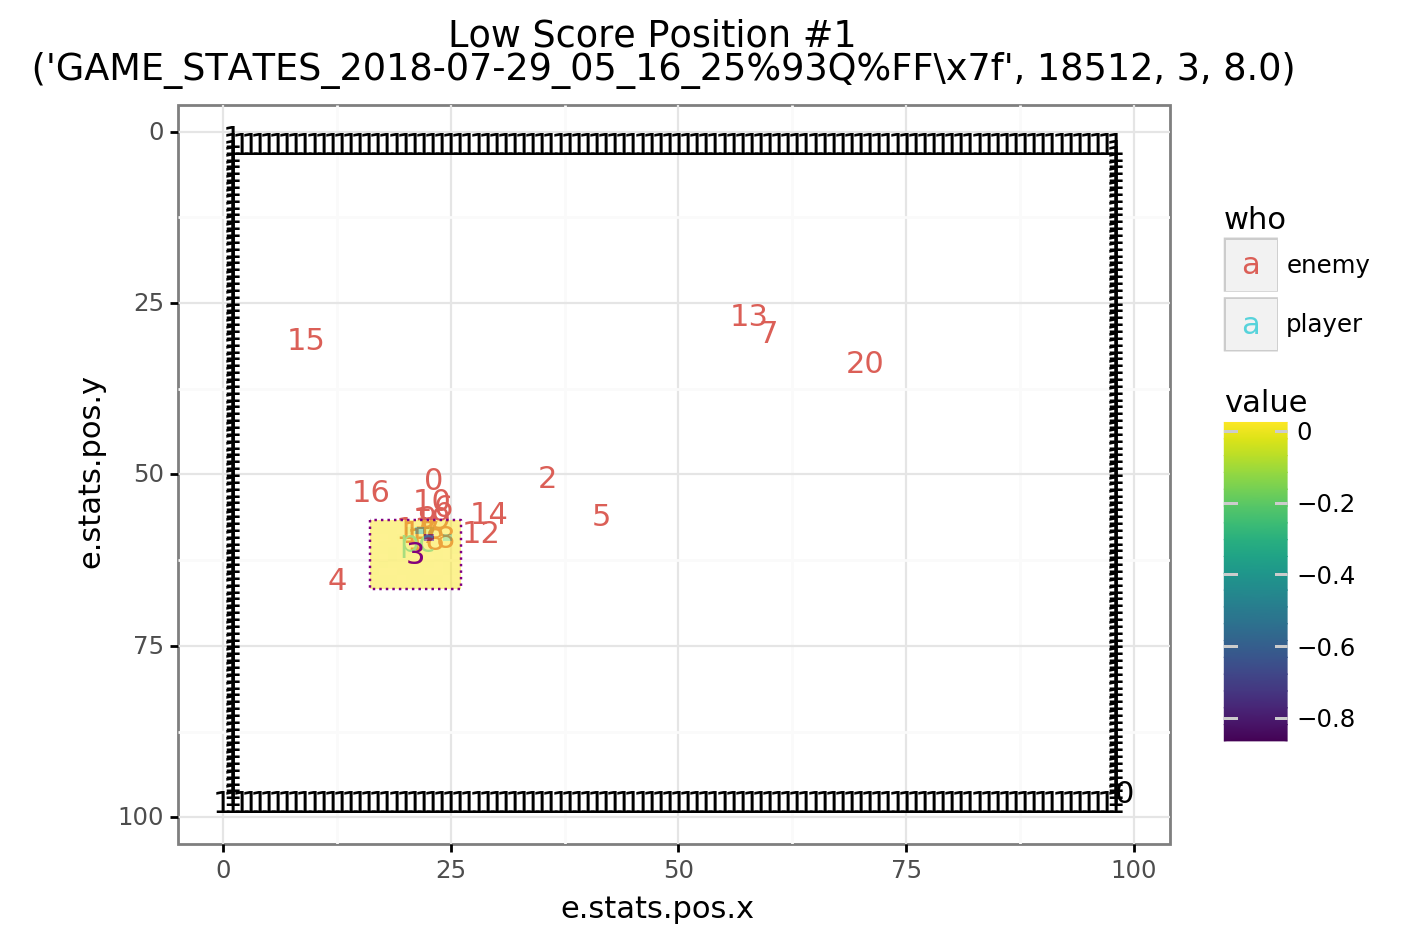

<ggplot: (7654243192)>

In [37]:
p + ggtitle(f'Low Score Position #{score_idx+1} \n {low_score_idxs[score_idx]}')

In [38]:
display(text)

(               feature_value      shap
 e.pc.dy            -1.681843  0.005992
 is_MOVE_NORTH       0.000000  0.001712
 is_MOVE_WEST        0.000000  0.001411
 is_MOVE_EAST        0.000000  0.001097
 is_MOVE_SOUTH       0.000000  0.000507
 e.stats.mp          0.000000  0.000000
 pc.stats.mp        12.000000 -0.000418
 e.stats.pos.y      61.642483 -0.003408
 is_NONE             1.000000 -0.006373
 e.pc.dx             0.194891 -0.011086
 e.stats.pos.x      21.123678 -0.107563
 e.stats.hp         50.000000 -0.318477
 pc.stats.hp        40.000000 -0.480877,
 R                                0.000000
 R_discount                     -28.877932
 entity_hp                       50.000000
 entity_hp_diff                   0.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000000
 is_pc_alive_diff                 0.000000
 pc_hp   

In [39]:
score_idx = 1
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=low_score_idxs[score_idx],
)

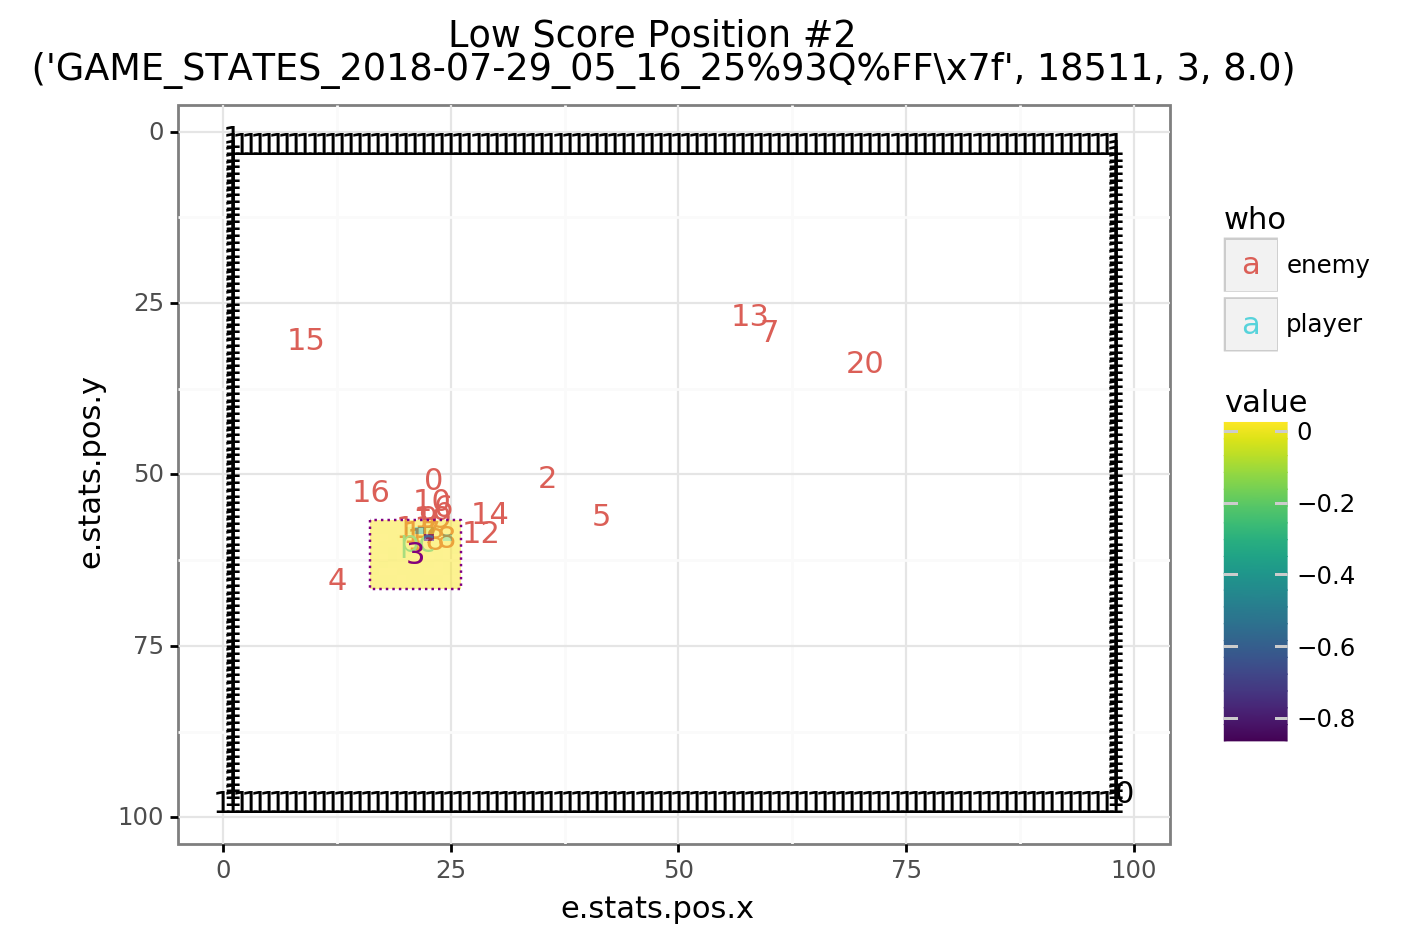

<ggplot: (7571221452)>

In [40]:
p + ggtitle(f'Low Score Position #{score_idx+1} \n {low_score_idxs[score_idx]}')

In [41]:
display(text)

(               feature_value      shap
 e.pc.dy            -1.681843  0.005992
 is_MOVE_NORTH       0.000000  0.001712
 is_MOVE_WEST        0.000000  0.001411
 is_MOVE_EAST        0.000000  0.001097
 is_MOVE_SOUTH       0.000000  0.000507
 e.stats.mp          0.000000  0.000000
 pc.stats.mp        12.000000 -0.000418
 e.stats.pos.y      61.642483 -0.003408
 is_NONE             1.000000 -0.006373
 e.pc.dx             0.194891 -0.011086
 e.stats.pos.x      21.123678 -0.107563
 e.stats.hp         50.000000 -0.318477
 pc.stats.hp        40.000000 -0.480877,
 R                                0.000000
 R_discount                     -23.102346
 entity_hp                       50.000000
 entity_hp_diff                   0.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000000
 is_pc_alive_diff                 0.000000
 pc_hp   

In [42]:
score_idx = 2
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=low_score_idxs[score_idx],
)

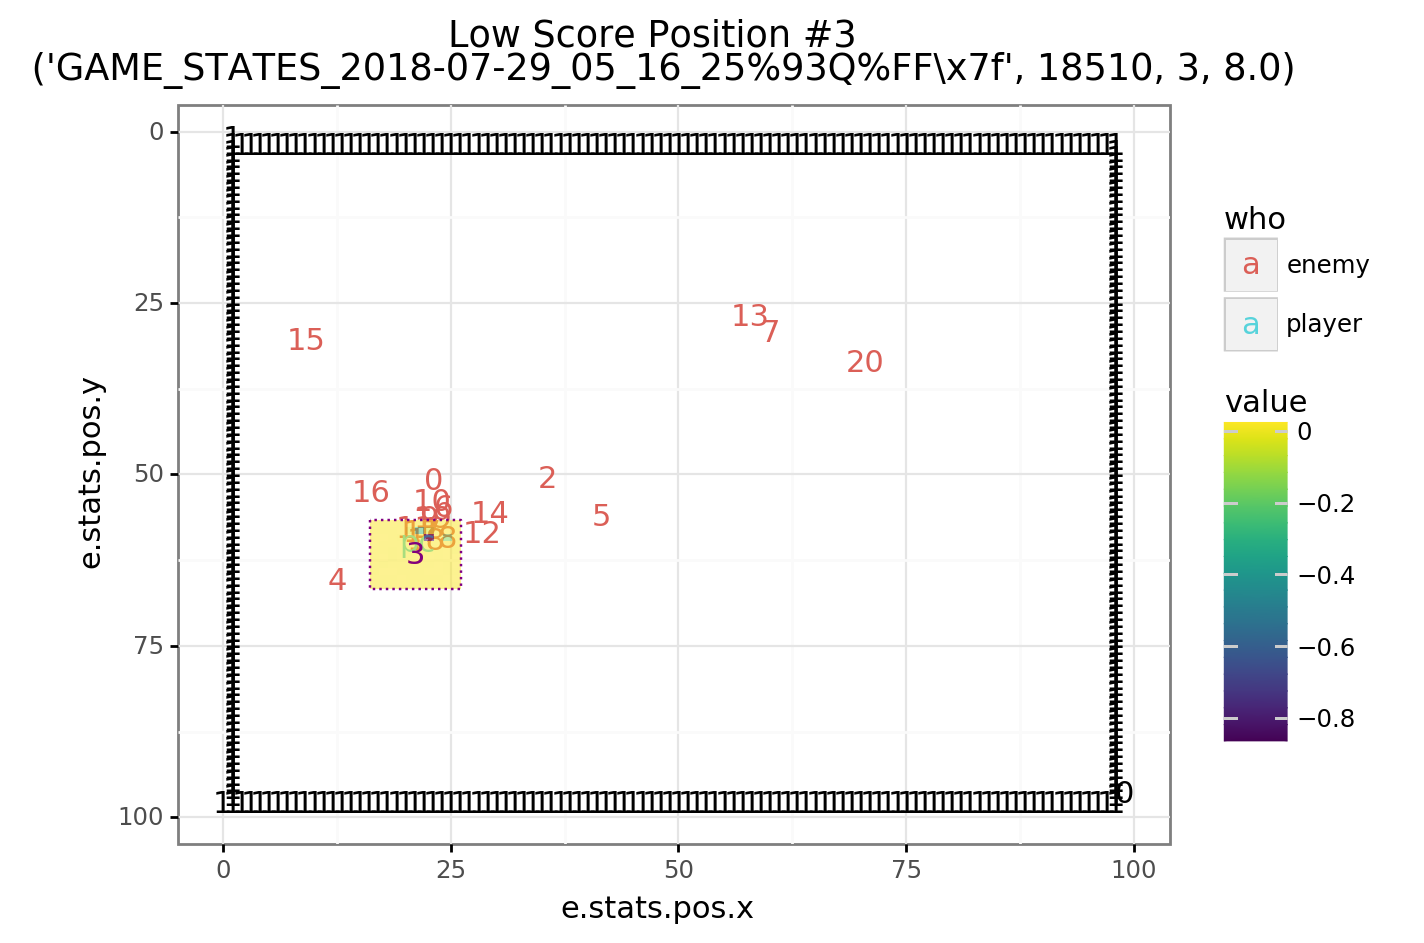

<ggplot: (-9223372029283507221)>

In [43]:
p + ggtitle(f'Low Score Position #{score_idx+1} \n {low_score_idxs[score_idx]}')

In [44]:
display(text)

(               feature_value      shap
 e.pc.dy            -1.681843  0.005992
 is_MOVE_NORTH       0.000000  0.001712
 is_MOVE_WEST        0.000000  0.001411
 is_MOVE_EAST        0.000000  0.001097
 is_MOVE_SOUTH       0.000000  0.000507
 e.stats.mp          0.000000  0.000000
 pc.stats.mp        12.000000 -0.000418
 e.stats.pos.y      61.642483 -0.003408
 is_NONE             1.000000 -0.006373
 e.pc.dx             0.194891 -0.011086
 e.stats.pos.x      21.123678 -0.107563
 e.stats.hp         50.000000 -0.318477
 pc.stats.hp        40.000000 -0.480877,
 R                                0.000000
 R_discount                     -18.481877
 entity_hp                       50.000000
 entity_hp_diff                   0.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000000
 is_pc_alive_diff                 0.000000
 pc_hp   

### High Score Positions

In [45]:
score_idx = 0
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=hi_score_idxs[score_idx],
)

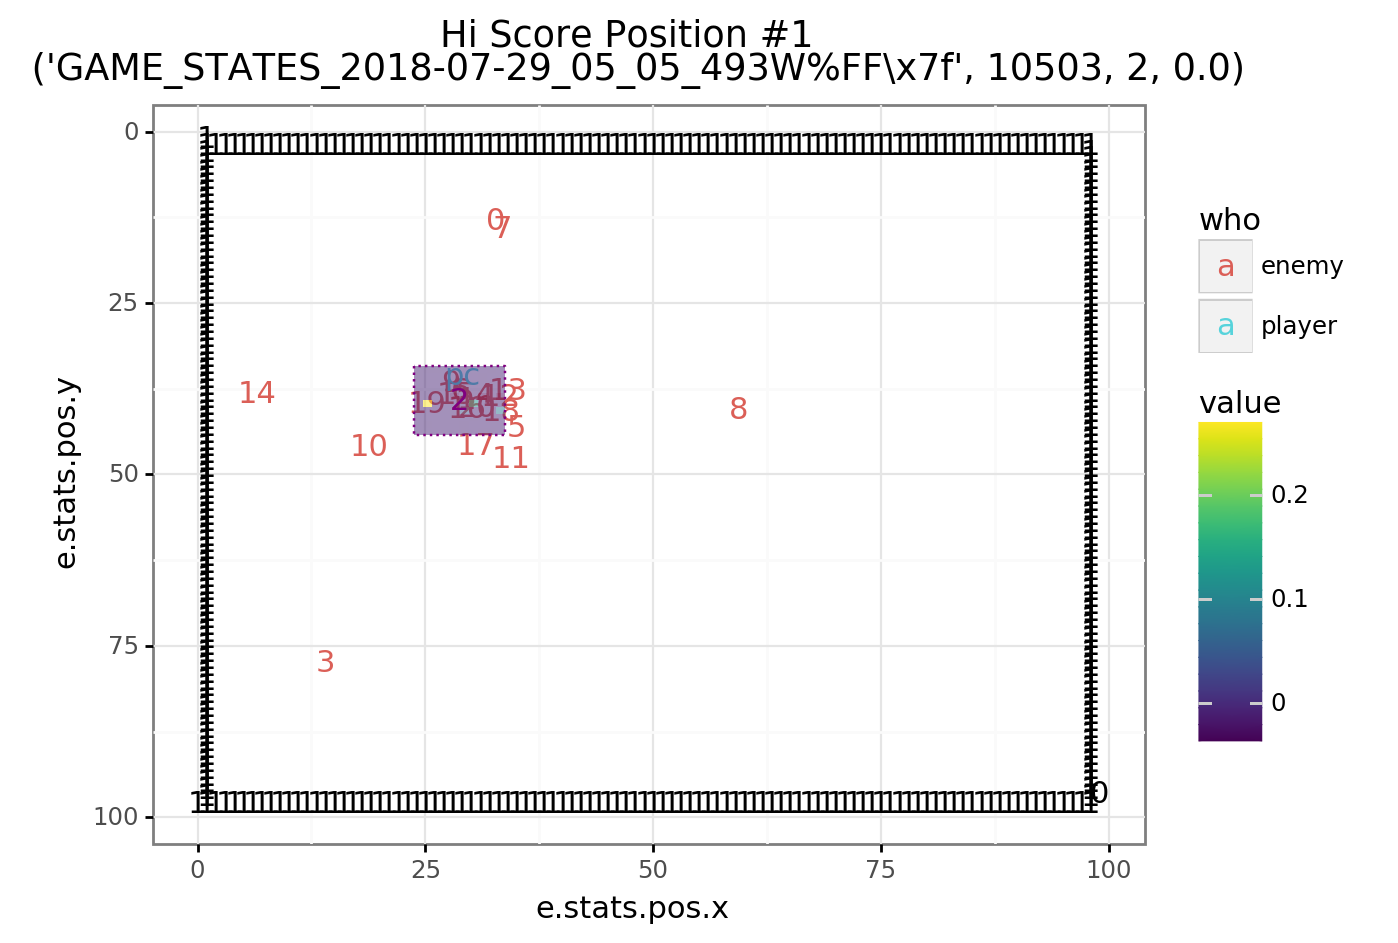

<ggplot: (7654894284)>

In [46]:
p + ggtitle(f'Hi Score Position #{score_idx+1} \n {hi_score_idxs[score_idx]}')

In [47]:
display(text)

(               feature_value      shap
 e.stats.hp         45.000000  0.060269
 pc.stats.hp        62.000000  0.039962
 e.stats.pos.x      28.746241  0.025597
 is_MOVE_WEST        0.000000  0.001104
 is_MOVE_EAST        0.000000  0.001087
 is_MOVE_NORTH       0.000000  0.000895
 is_MOVE_SOUTH       0.000000  0.000465
 pc.stats.mp        12.000000  0.000115
 e.stats.mp          0.000000  0.000000
 e.pc.dx             0.308309 -0.000647
 e.pc.dy            -3.549492 -0.002055
 is_NONE             1.000000 -0.003267
 e.stats.pos.y      39.180443 -0.006871,
 R                                1.000000
 R_discount                       2.303316
 entity_hp                       45.000000
 entity_hp_diff                   1.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000000
 is_pc_alive_diff                 0.000000
 pc_hp   

In [48]:
score_idx = 1
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=hi_score_idxs[score_idx],
)

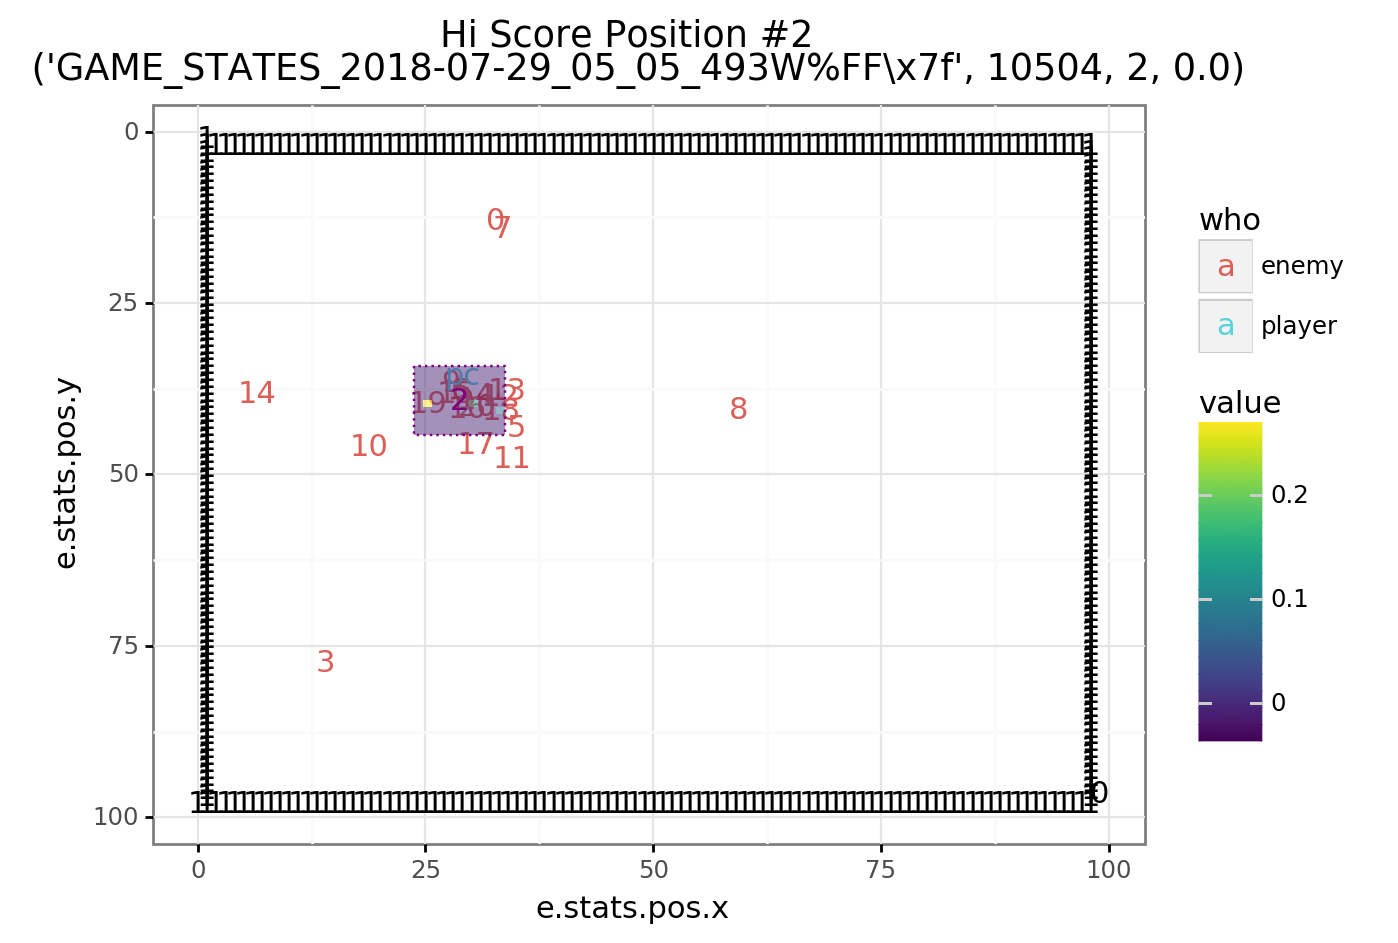

<ggplot: (-9223372029271551081)>

In [49]:
p + ggtitle(f'Hi Score Position #{score_idx+1} \n {hi_score_idxs[score_idx]}')

In [50]:
display(text)

(               feature_value      shap
 e.stats.hp         46.000000  0.059911
 pc.stats.hp        62.000000  0.039795
 e.stats.pos.x      28.746241  0.025345
 is_MOVE_WEST        0.000000  0.001106
 is_MOVE_EAST        0.000000  0.001090
 is_MOVE_NORTH       0.000000  0.000895
 is_MOVE_SOUTH       0.000000  0.000464
 pc.stats.mp        12.000000  0.000114
 e.stats.mp          0.000000  0.000000
 e.pc.dx             0.308309 -0.000609
 e.pc.dy            -3.649491 -0.002077
 is_NONE             1.000000 -0.003286
 e.stats.pos.y      39.180443 -0.006872,
 R                                1.000000
 R_discount                       1.629146
 entity_hp                       46.000000
 entity_hp_diff                   1.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000000
 is_pc_alive_diff                 0.000000
 pc_hp   

In [51]:
score_idx = 2
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=hi_score_idxs[score_idx],
)

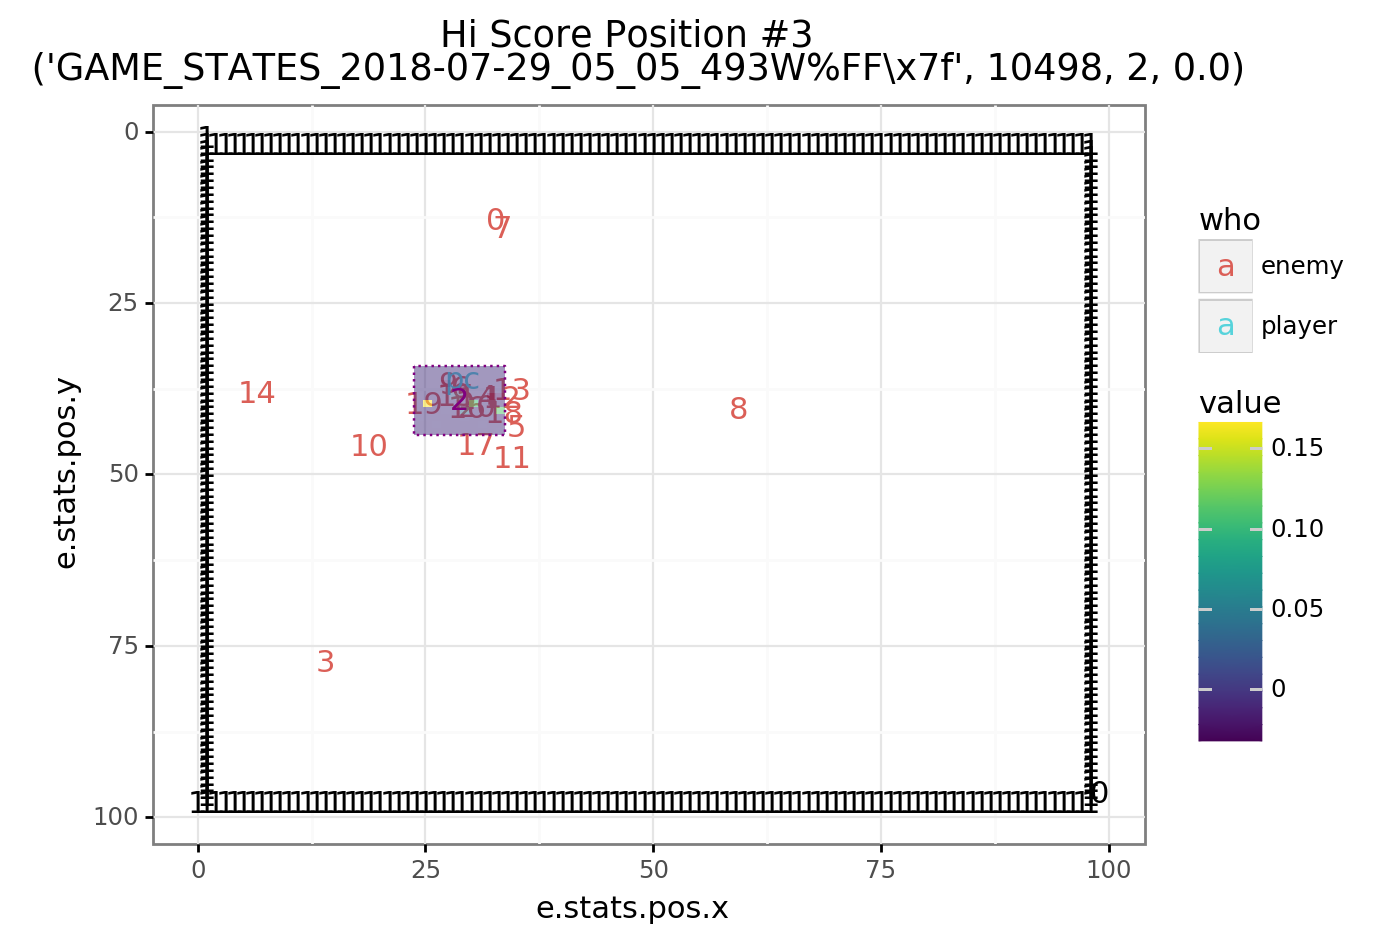

<ggplot: (-9223372029217641244)>

In [52]:
p + ggtitle(f'Hi Score Position #{score_idx+1} \n {hi_score_idxs[score_idx]}')

In [53]:
display(text)

(               feature_value      shap
 e.stats.hp         40.000000  0.053525
 pc.stats.hp        62.000000  0.038837
 e.stats.pos.x      28.746241  0.020008
 is_MOVE_WEST        0.000000  0.001138
 is_MOVE_EAST        0.000000  0.001068
 is_MOVE_NORTH       0.000000  0.000863
 is_MOVE_SOUTH       0.000000  0.000425
 pc.stats.mp        12.000000  0.000164
 e.stats.mp          0.000000  0.000000
 e.pc.dx             0.308309 -0.000242
 e.pc.dy            -3.049500 -0.000935
 is_NONE             1.000000 -0.003504
 e.stats.pos.y      39.180443 -0.004600,
 R                                1.000000
 R_discount                       4.116351
 entity_hp                       40.000000
 entity_hp_diff                   1.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000000
 is_pc_alive_diff                 0.000000
 pc_hp   

# Save model for serving in C

In [54]:
MODEL_DIR = '/Users/leopekelis/flare/flare-ai/models/'
now_time = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME = f'mdp_v0_{now_time}'

MODEL_PATH = MODEL_DIR + MODEL_NAME + '_saved_model'

In [64]:
display(MODEL_PATH)

'/Users/leopekelis/flare/flare-ai/models/mdp_v0_20190814_210649_saved_model'

In [55]:
sess.graph.collections

[('__varscope',),
 ('__variable_store',),
 'variables',
 'model_variables',
 'is_training',
 'is_training_ops',
 'trainable_variables',
 'cond_context',
 'train_op']

In [56]:
model.input

<tf.Tensor 'batch_normalization_input:0' shape=(?, 113) dtype=float32>

In [57]:
model.output

<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 1) dtype=float32>

In [58]:
signature = tf.saved_model.signature_def_utils.predict_signature_def(                                                                        
    inputs={'inputs': model.input}, outputs={'prediction': model.output})

In [59]:
valid_prediction_signature = tf.saved_model.signature_def_utils.is_valid_signature(signature)
if(valid_prediction_signature == False):
    raise ValueError("Error: Prediction signature not valid!")

In [60]:
builder = tf.saved_model.builder.SavedModelBuilder(MODEL_PATH)  

legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

builder.add_meta_graph_and_variables(                                                                                                        
    sess=sess,                                                                                                                    
    tags=[tf.saved_model.tag_constants.SERVING],                                                                                             
    signature_def_map={                                                                                                                      
        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:                                                                
            signature                                                                                                                         
    },
    legacy_init_op=legacy_init_op
)

Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


In [61]:
builder.save()

INFO:tensorflow:SavedModel written to: /Users/leopekelis/flare/flare-ai/models/mdp_v0_20190814_210649_saved_model/saved_model.pb


b'/Users/leopekelis/flare/flare-ai/models/mdp_v0_20190814_210649_saved_model/saved_model.pb'

## Reload saved_model to make sure it works

In [63]:
with tf.Session(graph=tf.Graph()) as sess:
    # saved_model_name = 'median_time_to_damage_20180805_094041_saved_model'
    # saved_model_name = 'mdp_v0_20190101_113200_saved_model'
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], MODEL_PATH)
    #display(sess.graph_def)
    print(sess.graph.get_operations())
    

INFO:tensorflow:Restoring parameters from /Users/leopekelis/flare/flare-ai/models/mdp_v0_20190814_210649_saved_model/variables/variables
[<tf.Operation 'is_training/Initializer/Const' type=Const>, <tf.Operation 'is_training' type=VariableV2>, <tf.Operation 'is_training/Assign' type=Assign>, <tf.Operation 'is_training/read' type=Identity>, <tf.Operation 'Assign/value' type=Const>, <tf.Operation 'Assign' type=Assign>, <tf.Operation 'Assign_1/value' type=Const>, <tf.Operation 'Assign_1' type=Assign>, <tf.Operation 'init' type=NoOp>, <tf.Operation 'Placeholder' type=Placeholder>, <tf.Operation 'Assign_2' type=Assign>, <tf.Operation 'batch_normalization_input' type=Placeholder>, <tf.Operation 'batch_normalization/gamma/Initializer/ones' type=Const>, <tf.Operation 'batch_normalization/gamma' type=VarHandleOp>, <tf.Operation 'batch_normalization/gamma/IsInitialized/VarIsInitializedOp' type=VarIsInitializedOp>, <tf.Operation 'batch_normalization/gamma/Assign' type=AssignVariableOp>, <tf.Operat

# Appendix

In [28]:
Action = action_features.Action

In [29]:
def action_from_feature(row: pd.Series) -> Action:
    idx = row[action_features.action_feature_names()].reset_index(drop=True).idxmax()
    return Action(idx)

In [30]:
def pos_from_action(pos, action):
    new_pos = pos.rename(lambda x: x + '_end')
    
    if action == Action.MOVE_NORTH:
        new_pos = new_pos + [0.0, 1.0]
    elif action == Action.MOVE_SOUTH:
        new_pos = new_pos + [0.0, -1.0]
    elif action == Action.MOVE_EAST:
        new_pos = new_pos + [1.0, 0.0]
    elif action == Action.MOVE_WEST:
        new_pos = new_pos + [-1.0, 0.0]
    
    return pd.DataFrame(pd.concat([pos,new_pos], axis=0)).T

In [79]:
def diagnostic_display(X,y,idx,title=''):
    row = X.loc[idx, :]
    display(row[[c for c in X.columns if not c.startswith('o_')]])
    display(y.loc[idx, :].filter(regex='(entity|pc|R)'))

    action = action_from_feature(row)
    arrow_df = pos_from_action(row[['e.stats.pos.x','e.stats.pos.y']], action)
    
    file_name = row.name[0]
    
    vision_df = pd.DataFrame(
        [{
            'xmin': row['e.stats.pos.x'] - feature_utils.VISION_DIMENSIONS[0] / 2,
            'ymin': row['e.stats.pos.y'] - feature_utils.VISION_DIMENSIONS[1] / 2,
            'xmax': row['e.stats.pos.x'] + feature_utils.VISION_DIMENSIONS[0] / 2,
            'ymax': row['e.stats.pos.y'] + feature_utils.VISION_DIMENSIONS[1] / 2,
        }]
    )
    
    return (
        plot_utils.plot_state(game_states[file_name][idx[1]],[collision_layer],['black'])
        + geom_segment(data = arrow_df, mapping = aes(x = 'e.stats.pos.x', 
                                                      y = 'e.stats.pos.y',
                                                      xend = 'e.stats.pos.x_end',
                                                      yend = 'e.stats.pos.y_end'),
                       arrow = arrow() if action is not Action.NONE else None,
                       color = 'purple',
                       size = 1,
                       alpha = 0.5)
        + geom_text(data = pd.DataFrame([row]).assign(entity=row.name[2]),
                    mapping = aes(x='e.stats.pos.x', y='e.stats.pos.y', label='entity'),
                    color = 'purple')
        + geom_rect(data = vision_df, 
                    mapping = aes(xmin='xmin', ymin='ymin', xmax='xmax', ymax='ymax'),
                    fill=None,
                    color='purple',
                    linetype='dotted')
        + ggtitle(title)
    )

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    28.500000
e.stats.pos.y    87.574997
pc.stats.hp      90.000000
pc.stats.mp      10.000000
e.pc.dx          22.000000
e.pc.dy         -37.074997
is_NONE           0.000000
is_MOVE_NORTH     0.000000
is_MOVE_EAST      0.000000
is_MOVE_SOUTH     1.000000
is_MOVE_WEST      0.000000
Name: (GAME_STATES_2018-07-29_03_48_35MW%FF, 1, 3, 0.0), dtype: float64

R                                0.0
R_discount                       0.0
entity_hp                       50.0
entity_hp_diff                   0.0
is_entity_alive                  1.0
is_entity_alive_dead_counter     0.0
is_entity_alive_diff             0.0
is_pc_alive                      1.0
is_pc_alive_dead_counter         0.0
is_pc_alive_diff                 0.0
pc_hp                           90.0
pc_hp_diff                       0.0
Name: (GAME_STATES_2018-07-29_03_48_35MW%FF, 1, 3, 0.0), dtype: float64

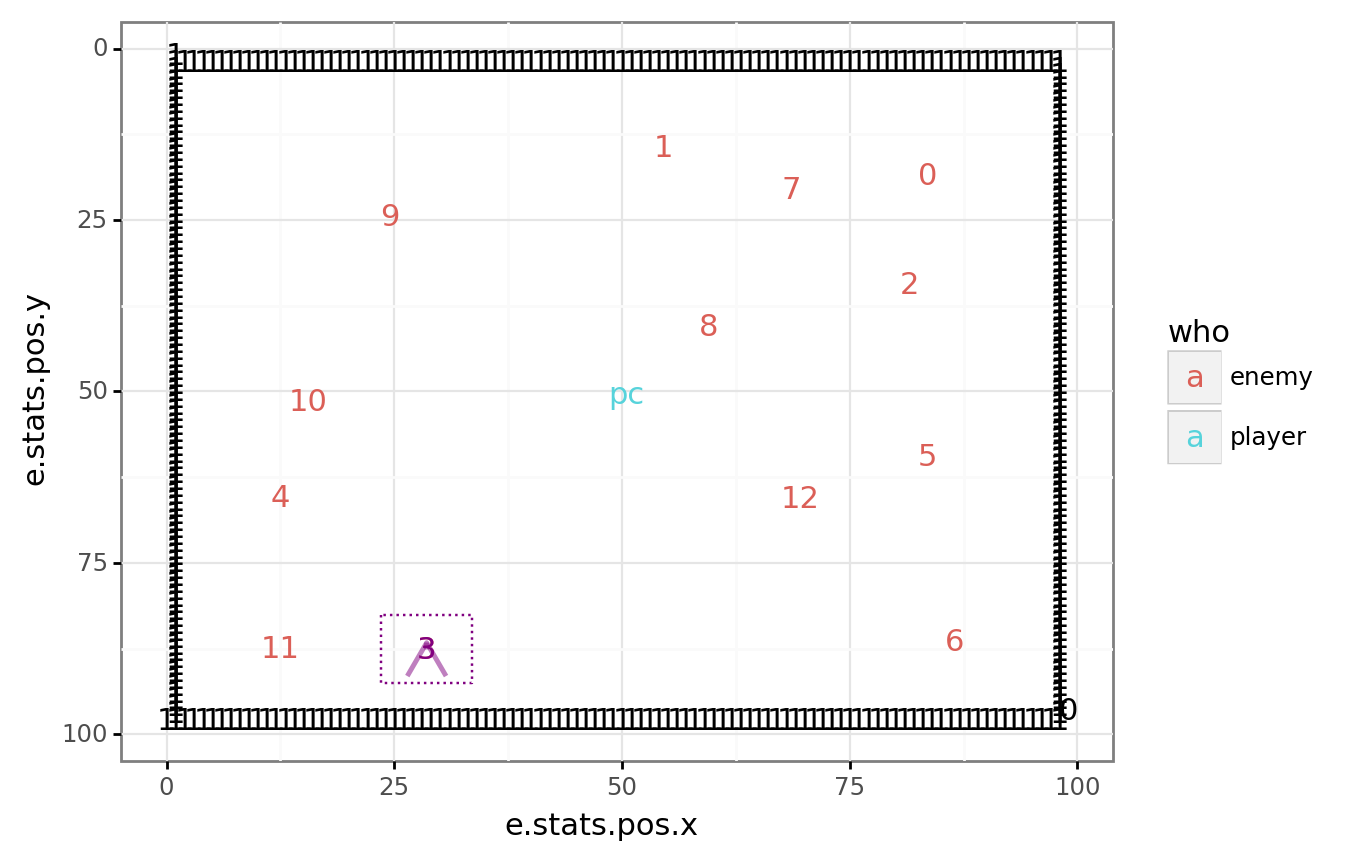

<ggplot: (7648199593)>

In [107]:
diagnostic_display(X, y, test_idx)

In [308]:
test_idx = ('GAME_STATES_2018-07-29_03_48_35MW%FF\x7f', 1, 3, 0)

In [309]:
(text, p) = diagnositic_viz.display(
    X=X,
    y=y,
    states=game_states,
    idx=test_idx,
)

In [311]:
text

(               feature_value          shap
 e.stats.pos.y      87.574997  5.564747e-04
 e.pc.dy           -37.074997  2.441557e-05
 e.stats.pos.x      28.500000  2.029399e-05
 e.stats.hp         50.000000  7.634193e-06
 is_NONE             0.000000  2.891270e-06
 is_MOVE_SOUTH       1.000000  1.053208e-06
 e.stats.mp          0.000000  0.000000e+00
 is_MOVE_WEST        0.000000 -1.842703e-08
 is_MOVE_EAST        0.000000 -5.964370e-07
 is_MOVE_NORTH       0.000000 -6.042952e-07
 pc.stats.mp        10.000000 -3.984314e-05
 pc.stats.hp        90.000000 -6.121725e-05
 e.pc.dx            22.000000 -1.322185e-04,
 R                                0.000000
 R_discount                       0.000000
 entity_hp                       50.000000
 entity_hp_diff                   0.000000
 is_entity_alive                  1.000000
 is_entity_alive_dead_counter     0.000000
 is_entity_alive_diff             0.000000
 is_pc_alive                      1.000000
 is_pc_alive_dead_counter         0.000

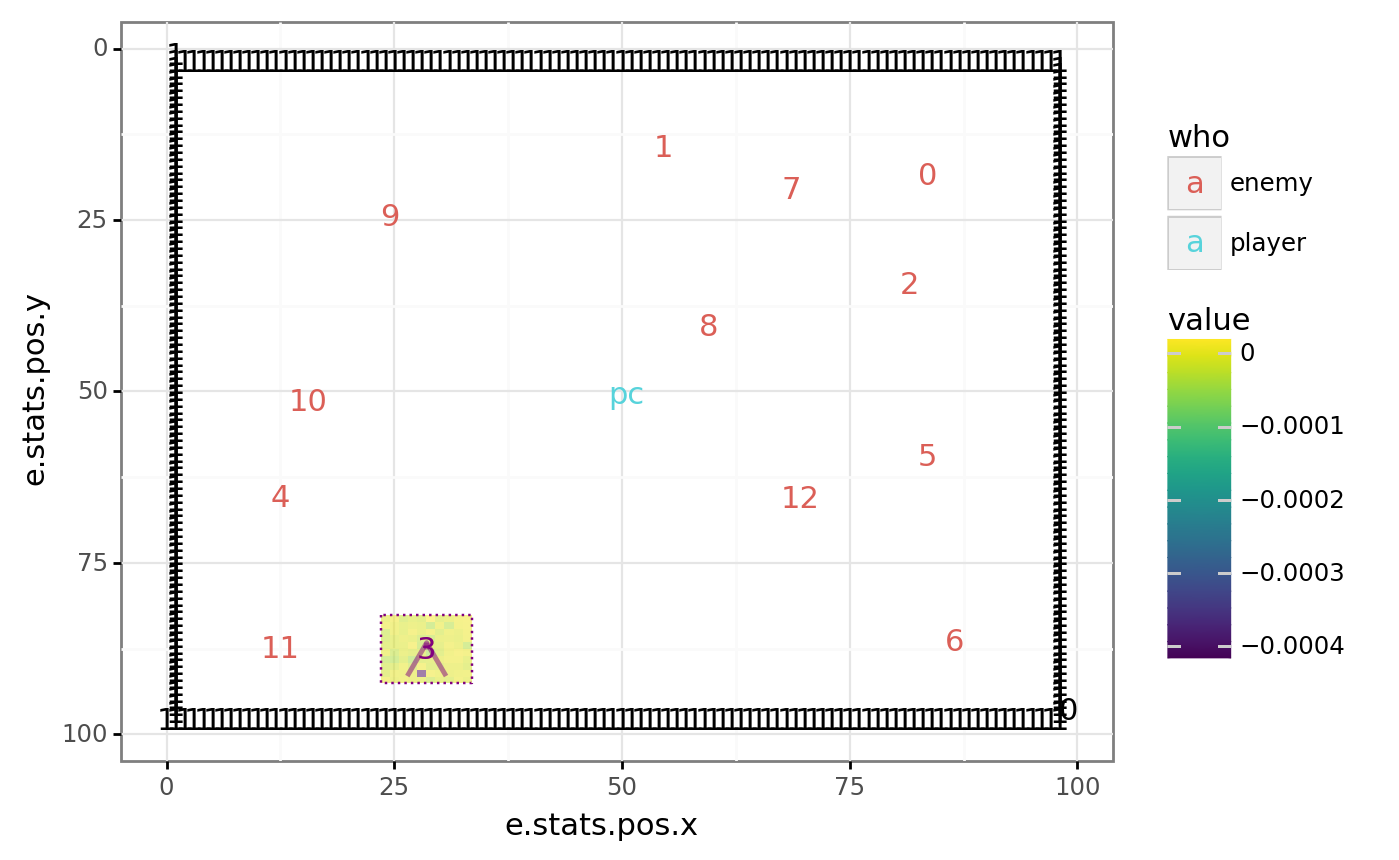

<ggplot: (7664141288)>

In [310]:
p

### Interactive panel for diagnostics

tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir=MODEL_PATH
)